In [ ]:
from google.colab import drive

# # Loading data to colab
drive.mount('/content/drive')

!mkdir Dataset
!cp -r /content/drive/MyDrive/

Mounted at /content/drive
cp: missing destination file operand after '/content/drive/MyDrive/'
Try 'cp --help' for more information.


### Libraries

In [ ]:

!pip install pyspark
!pip install neurokit2
!pip install ecg_plot



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d78702a4a265fd5e5ce6621105d38d628633028689dd1da7fb990026f916f595
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.4 MB/s eta 0:00:00


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType


import numpy as np
import statistics

import ecg_plot
import neurokit2 as nk
import matplotlib.pyplot as plt
import seaborn as sns

### Spark session and dataset load



In [ ]:
spark = SparkSession.builder.appName("Data Understanding").getOrCreate()

In [ ]:
df = spark.read.csv('/content/drive/Shareddrives/DDAM - Project/ischemia_dataset.csv', header=True, inferSchema=True)

# Data preparation



#### Type and name columns conversion

In [ ]:
df.describe

<bound method DataFrame.describe of DataFrame[NomeFile: string, StartingValue1: int, StartingValue2: int, StartingValue3: int, StartingValue4: int, StartingValue5: int, StartingValue6: int, StartingValue7: int, StartingValue8: int, StartingValue9: int, StartingValue10: int, StartingValue11: int, StartingValue12: int, SumValues1: int, SumValues2: int, SumValues3: int, SumValues4: int, SumValues5: int, SumValues6: int, SumValues7: int, SumValues8: int, SumValues9: int, SumValues10: int, SumValues11: int, SumValues12: int, Age: double, Sex: string, Dx: string, New_der1: string, New_der2: string, New_der3: string, New_der4: string, New_der5: string, New_der6: string, New_der7: string, New_der8: string, New_der9: string, New_der10: string, New_der11: string, New_der12: string]>

In [ ]:
# derivations casting
new_der_columns = [f"New_der{i}" for i in range(1, 13)]
for col_name in new_der_columns:
    df = df.withColumn(col_name, split(col(col_name), ",").cast("array<int>"))

df = df.withColumn('Age', when(col('Age') == 'NaN', None).otherwise(col('Age').cast('int')))

In [ ]:
renaming_colums = {
    'NomeFile' : 'Patient_ID',
    'Dx': 'DiagnosticCode',
}

for orig_column, new_name in renaming_colums.items():
    df = df.withColumnRenamed(orig_column, new_name)

In [ ]:
df.printSchema()

root
 |-- Patient_ID: string (nullable = true)
 |-- StartingValue1: integer (nullable = true)
 |-- StartingValue2: integer (nullable = true)
 |-- StartingValue3: integer (nullable = true)
 |-- StartingValue4: integer (nullable = true)
 |-- StartingValue5: integer (nullable = true)
 |-- StartingValue6: integer (nullable = true)
 |-- StartingValue7: integer (nullable = true)
 |-- StartingValue8: integer (nullable = true)
 |-- StartingValue9: integer (nullable = true)
 |-- StartingValue10: integer (nullable = true)
 |-- StartingValue11: integer (nullable = true)
 |-- StartingValue12: integer (nullable = true)
 |-- SumValues1: integer (nullable = true)
 |-- SumValues2: integer (nullable = true)
 |-- SumValues3: integer (nullable = true)
 |-- SumValues4: integer (nullable = true)
 |-- SumValues5: integer (nullable = true)
 |-- SumValues6: integer (nullable = true)
 |-- SumValues7: integer (nullable = true)
 |-- SumValues8: integer (nullable = true)
 |-- SumValues9: integer (nullable = true)

#### Diagnostic code encoding
(1 hearth attack (Diagnostic code 426783006) | 0 otherwise)

In [ ]:
sqlCtx = SQLContext(spark)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
#Verify how many people with heart attack
df.createOrReplaceTempView("countHA")
sqlCtx.sql("""SELECT COUNT(*) FROM countHA WHERE FIND_IN_SET('426783006', DiagnosticCode) > 0 """).show()

+--------+
|count(1)|
+--------+
|    1385|
+--------+



In [ ]:
#Replace with 1 if the patient have heart attack, 0 otherwise
df = df.withColumn('DiagnosticCode', F.when(F.col('DiagnosticCode').contains('426783006'), 1).otherwise(0))

In [ ]:
#Just a check to see if there's consistency with numbers, so 790 has 0 in Dx --> no heart attack but other pathologies
df.createOrReplaceTempView("check")
sqlCtx.sql("""SELECT DiagnosticCode,COUNT(*) FROM check GROUP BY DiagnosticCode""").show()

+--------------+--------+
|DiagnosticCode|count(1)|
+--------------+--------+
|             1|    1385|
|             0|     790|
+--------------+--------+



### Check missing *values*

#### Age missing values with the mean age stratified by Sex

In [ ]:
age_df = df.filter(col('Age').isNull())
age_df.select('Patient_ID', 'Age', 'Sex').show()

+----------+----+------+
|Patient_ID| Age|   Sex|
+----------+----+------+
|   HR00923|NULL|  Male|
|   HR02103|NULL|Female|
|   HR17653|NULL|Female|
|   HR10563|NULL|Female|
|   HR06892|NULL|  Male|
|   HR10177|NULL|Female|
|   HR14535|NULL|Female|
|   HR14497|NULL|Female|
|   HR12958|NULL|Female|
|   HR02008|NULL|Female|
|   HR00637|NULL|  Male|
|   HR14331|NULL|Female|
|   HR00727|NULL|Female|
|   HR06816|NULL|Female|
|   HR03827|NULL|  Male|
|   HR03238|NULL|Female|
|   HR02724|NULL|  Male|
|   HR03000|NULL|Female|
|   HR10054|NULL|Female|
+----------+----+------+



In [ ]:
# Calculate mean for each sex
age_mean_by_sex = (df.groupBy('Sex').agg((round(avg('Age')).cast('int')).alias('avg_age')))
# Add the mean to the df
df = df.join(age_mean_by_sex, 'Sex')

# Fill 'Age' missing values with the corresponding mean
df = df.withColumn('Age', when(col('Age').isNull(), col('avg_age')).otherwise(col('Age')))

df = df.drop('avg_age') # column not useful anymore

In [ ]:
age_df = df.filter(col('Patient_ID') == 'HR00923' )
age_df.select('Patient_ID', 'Age', 'Sex').show()

+----------+---+----+
|Patient_ID|Age| Sex|
+----------+---+----+
|   HR00923| 65|Male|
+----------+---+----+



In [ ]:
age_df = df.filter(col('Patient_ID') == 'HR10563' )
age_df.select('Patient_ID', 'Age', 'Sex').show()

+----------+---+------+
|Patient_ID|Age|   Sex|
+----------+---+------+
|   HR10563| 72|Female|
+----------+---+------+



In [ ]:
age_df = df.filter(col('Age').isNull())
age_df.select('Patient_ID', 'Age', 'Sex').show()

+----------+---+---+
|Patient_ID|Age|Sex|
+----------+---+---+
+----------+---+---+



In [ ]:
check_missing = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
check_missing.show()

+---+----------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+---+--------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+
|Sex|Patient_ID|StartingValue1|StartingValue2|StartingValue3|StartingValue4|StartingValue5|StartingValue6|StartingValue7|StartingValue8|StartingValue9|StartingValue10|StartingValue11|StartingValue12|SumValues1|SumValues2|SumValues3|SumValues4|SumValues5|SumValues6|SumValues7|SumValues8|SumValues9|SumValues10|SumValues11|SumValues12|Age|DiagnosticCode|New_der1|New_der2|New_der3|New_der4|New_der5|New_der6|New_der7|New_der8|New_der9|New_der10|New_der11|New_der12|
+---+----------+--------------+--------------+--------------+---------

### Feature extraction

##### Total Starting Values and Sum Values

In [ ]:
#TOT SUM StartingValue
df = df.withColumn("Tot_sum_startingValue",df.StartingValue1 + df.StartingValue2 + df.StartingValue3 + df.StartingValue4 +
                    df.StartingValue5 + df.StartingValue6 + df.StartingValue7 + df.StartingValue8 + df.StartingValue9 + df.StartingValue10
                    + df.StartingValue11 + df.StartingValue12)

In [ ]:
#TOT SUM SumValues
df = df.withColumn("Tot_sum_sumValue", df.SumValues1 + df.SumValues2 + df.SumValues3 + df.SumValues4 + df.SumValues5 + df.SumValues6
                   +df.SumValues7 + df.SumValues8 + df.SumValues9 + df.SumValues10 + df.SumValues11 + df.SumValues12)

##### Mean Bpm calculation for each derivation

In [ ]:
def mean_bpm(array):
    try:
        rr_intervals = nk.ecg_findpeaks(array, sampling_rate=500).get('ECG_R_Peaks')
        rr_intervals = nk.ecg_rate(rr_intervals)
        bpm_mean = int(rr_intervals.mean())
        return bpm_mean
    except:
        return 0.0

mean_array_r_r = F.udf(mean_bpm, IntegerType())

for i in range(1, 13):
    column_name = f"New_der{i}"
    new_column_name = f"Bpm_Mean{i}"
    df = df.withColumn(new_column_name, mean_array_r_r(column_name))

df.show()

+------+----------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+---+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+----------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+
|   Sex|Patient_ID|StartingValue1|StartingValue2|StartingValue3|StartingValue4|StartingValue5|StartingValue6|StartingValue7|StartingValue8|StartingValue9|StartingValue10|StartingValue11|StartingValue12|SumValues1|SumValues2|SumVa

##### Mean and std for significants groups of derivations

- Left leg: aVF, II e III
- Left arm: aVL, I, V5, V6
- Right arm: aVR, V1
- V2, V3, V4: significant sector for heart attack

In [ ]:
#fx to calculate the mean and std for the measurment take from the left leg and V2,V3,V4
def ll_V_mean(v1,v2,v3):
    array = v1+v2+v3
    return statistics.mean(array)



def ll_V_std(v1,v2,v3):
    array = v1+v2+v3
    return statistics.stdev(array)

ll_V_mean_udf = udf(ll_V_mean)
ll_V_std_udf = udf(ll_V_std)

In [ ]:
#fx to calculate the mean and std for the measurment take from the left arm
def al_mean(v1,v2,v3,v4):
    array = v1+v2+v3+v4
    return statistics.mean(array)

def al_std(v1,v2,v3,v4):
    array = v1+v2+v3+v4
    return statistics.stdev(array)



al_mean_udf = udf(al_mean)
al_std_udf = udf(al_std)

In [ ]:
#fx to calculate the mean and std for the measurment take from the right arm
def ar_mean(v1,v2):
    array = v1+v2
    return statistics.mean(array)

def ar_std(v1,v2):
    array = v1+v2
    return statistics.stdev(array)

ar_mean_udf = udf(ar_mean)
ar_std_udf = udf(ar_std)

In [ ]:
#Here apply all the fx
df = df.withColumn("leftleg_mean", ll_V_mean_udf(col('New_der2'),col('New_der3'),col('New_der6')))
df = df.withColumn("critical_mean", ll_V_mean_udf(col('New_der8'), col('New_der9'), col('New_der10')))
df = df.withColumn("leftarm_mean", al_mean_udf(col('New_der1'), col('New_der5'), col('New_der11'),col('New_der12')))
df = df.withColumn("rightarm_mean", ar_mean_udf(col('New_der4'), col('New_der7')))



df = df.withColumn("leftleg_std", ll_V_std_udf(col('New_der2'), col('New_der3'),col('New_der6')))
df = df.withColumn("critical_std", ll_V_std_udf(col('New_der8'), col('New_der9'), col('New_der10')))
df = df.withColumn("leftarm_std", al_std_udf(col('New_der1'), col('New_der5'), col('New_der11'),col('New_der12')))
df = df.withColumn("rightarm_std", ar_std_udf(col('New_der4'), col('New_der7')))

##### Feature creation taking into account all the derivations

In [ ]:
#overall mean and std for all
def tot_mean_array(v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12):
    array = v1 + v2 + v3 + v4 + v5 + v6 + v7 + v8 + v9 + v10 + v11 + v12
    return statistics.mean(array)
def tot_std_array(v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12):
    array = v1 + v2 + v3 + v4 + v5 + v6 + v7 + v8 + v9 + v10 + v11 + v12
    return statistics.stdev(array)

tot_mean_array_udf = udf(tot_mean_array)
tot_std_array_udf = udf(tot_std_array)


df = df.withColumn("total_der_mean", tot_mean_array_udf(col('New_der1'),col('New_der2'),col('New_der3'),col('New_der4'),
                                                       col('New_der5'),col('New_der6'),col('New_der7'),col('New_der8'),
                                                       col('New_der9'),col('New_der10'),col('New_der11'),col('New_der12')))

df = df.withColumn("total_der_std", tot_std_array_udf(col('New_der1'),col('New_der2'),col('New_der3'),col('New_der4'),
                                                       col('New_der5'),col('New_der6'),col('New_der7'),col('New_der8'),
                                                       col('New_der9'),col('New_der10'),col('New_der11'),col('New_der12')))

In [ ]:
# Resultant df
df.columns

['Sex',
 'Patient_ID',
 'StartingValue1',
 'StartingValue2',
 'StartingValue3',
 'StartingValue4',
 'StartingValue5',
 'StartingValue6',
 'StartingValue7',
 'StartingValue8',
 'StartingValue9',
 'StartingValue10',
 'StartingValue11',
 'StartingValue12',
 'SumValues1',
 'SumValues2',
 'SumValues3',
 'SumValues4',
 'SumValues5',
 'SumValues6',
 'SumValues7',
 'SumValues8',
 'SumValues9',
 'SumValues10',
 'SumValues11',
 'SumValues12',
 'Age',
 'DiagnosticCode',
 'New_der1',
 'New_der2',
 'New_der3',
 'New_der4',
 'New_der5',
 'New_der6',
 'New_der7',
 'New_der8',
 'New_der9',
 'New_der10',
 'New_der11',
 'New_der12',
 'Tot_sum_startingValue',
 'Tot_sum_sumValue',
 'Bpm_Mean1',
 'Bpm_Mean2',
 'Bpm_Mean3',
 'Bpm_Mean4',
 'Bpm_Mean5',
 'Bpm_Mean6',
 'Bpm_Mean7',
 'Bpm_Mean8',
 'Bpm_Mean9',
 'Bpm_Mean10',
 'Bpm_Mean11',
 'Bpm_Mean12',
 'leftleg_mean',
 'critical_mean',
 'leftarm_mean',
 'rightarm_mean',
 'leftleg_std',
 'critical_std',
 'leftarm_std',
 'rightarm_std',
 'total_der_mean',
 'to

# Data understanding

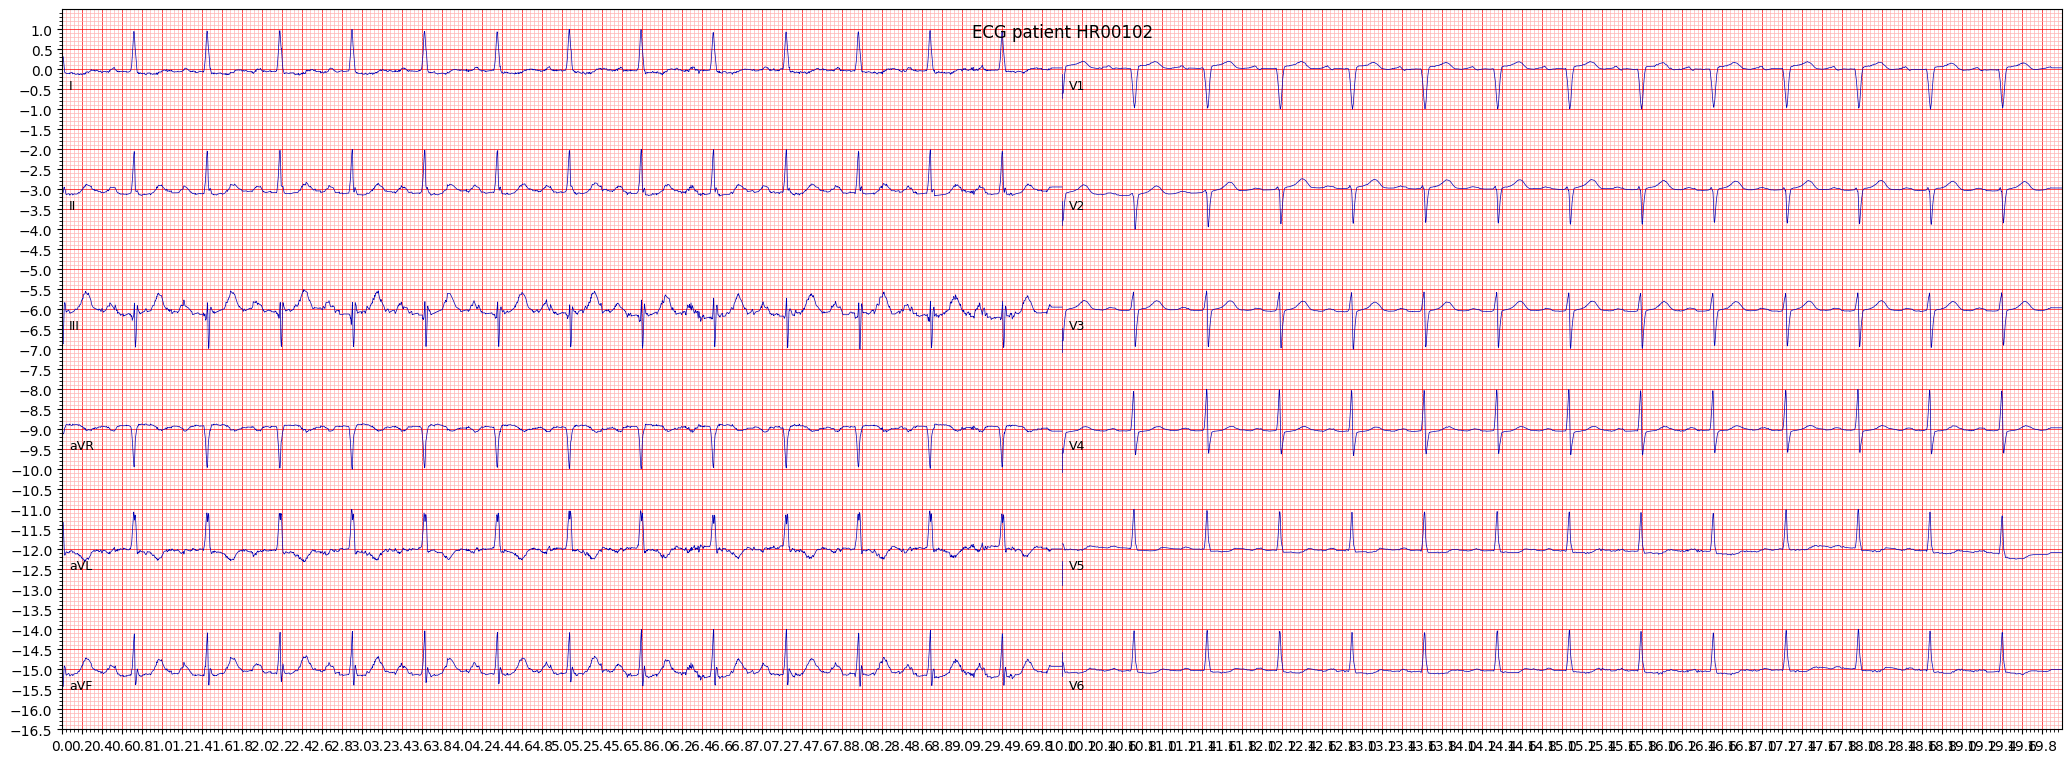

In [ ]:
patient_df = df.filter(col("Patient_ID") == "HR00102")

# Extract the ECG signal arrays for each lead
ecg_arrays = [col(f"New_der{i}") for i in range(1, 13)]
ecg_data = patient_df.select(*ecg_arrays).first()

# Scale each lead and store in a list
lead_data = [np.array(lead_array) / np.max(np.abs(lead_array)) for lead_array in ecg_data]

ecg_plot.plot(
    lead_data,
    sample_rate=500,
    title='ECG patient HR00102',
    lead_index=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],
)
ecg_plot.show()

In [ ]:
df.createOrReplaceTempView("check2")

# Query to select patients without heart attack
sql_query = """
    SELECT DiagnosticCode, Age, Sex
    FROM check2
    WHERE DiagnosticCode = 0
"""

df_NOHeartAttack = sqlCtx.sql(sql_query).toPandas()
grouped_NOHeartAttack = df_NOHeartAttack.groupby('Sex')['Age'].mean()

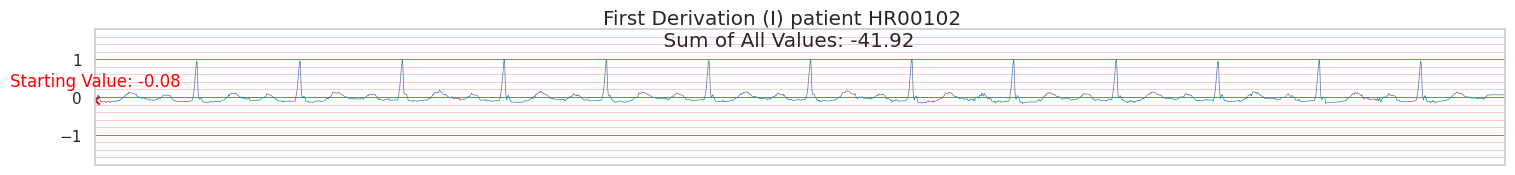

In [ ]:
sum_value = np.sum(lead_data[1])

ecg_plot.plot_1(lead_data[1], sample_rate=500, title=f'First Derivation (I) patient HR00102 \n Sum of All Values: {sum_value:.2f}')
plt.gca().axes.get_xaxis().set_visible(False)

start_value = lead_data[1][0]
plt.scatter(0, start_value, marker='x', color='red')
plt.annotate(f'Starting Value: {start_value:.2f}', (0, start_value), textcoords="offset points", xytext=(0, 10), ha='center', color='red')

plt.show()

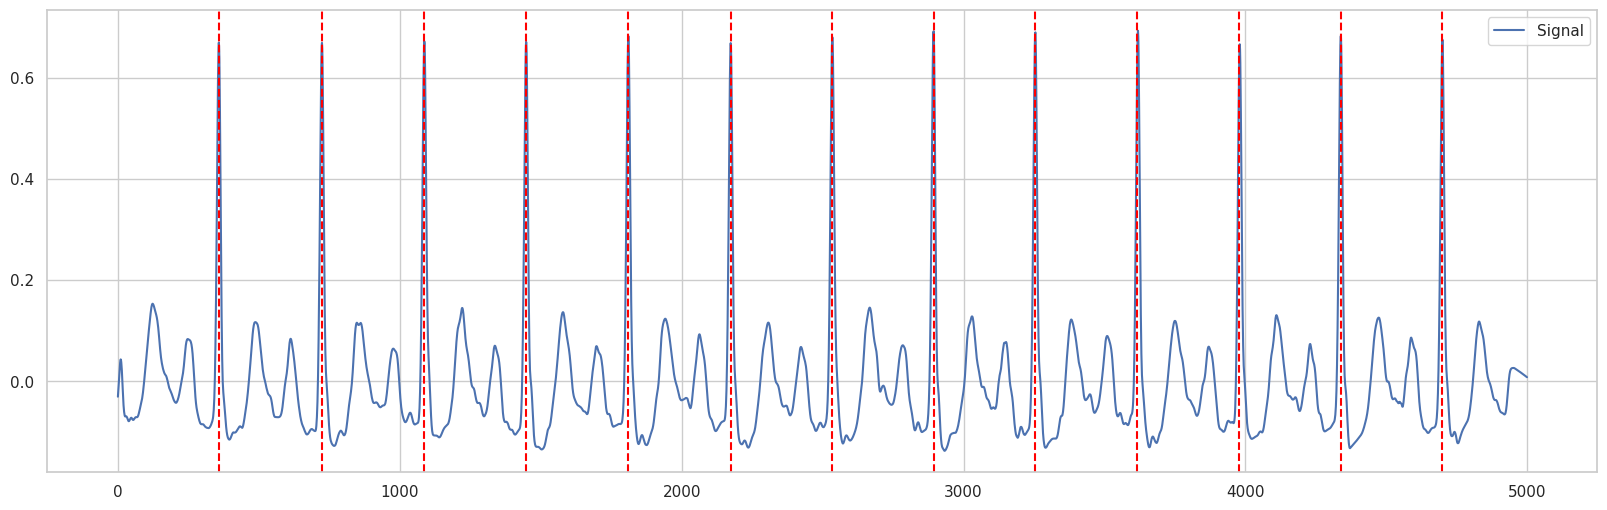

In [ ]:
signals, info = nk.ecg_process(lead_data[1], sampling_rate=500)
rpeaks = info["ECG_R_Peaks"] # Extract clean ECG and R-peaks location
cleaned_ecg = signals["ECG_Clean"]

plot = nk.events_plot(rpeaks, cleaned_ecg)

fig = plt.gcf()
fig.set_size_inches(20, 6)

In [ ]:
print(rpeaks) # it shows the positions of the peaks detected

[ 358  724 1087 1448 1811 2174 2535 2894 3255 3617 3978 4338 4699]


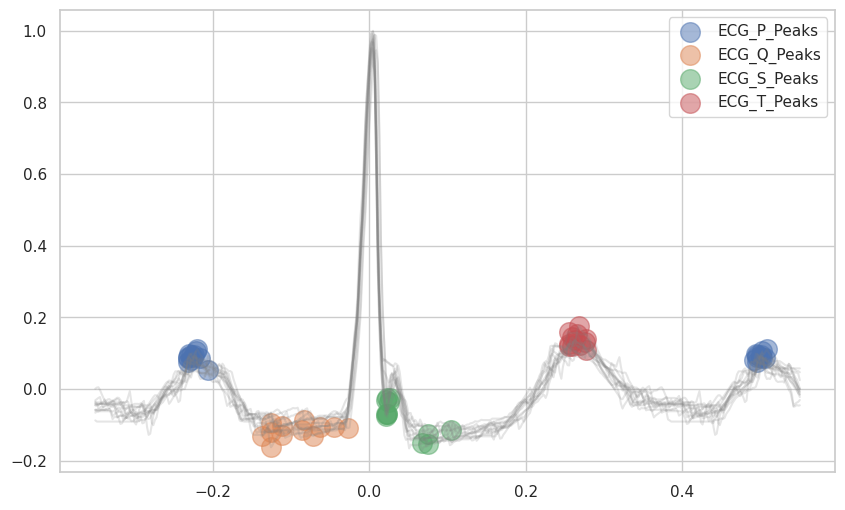

In [ ]:
rpeaks = info["ECG_R_Peaks"]
_, signals_peak = nk.ecg_delineate(lead_data[1],
                                 rpeaks,
                                 sampling_rate=500,
                                 method="peak",
                                 show=True,
                                 show_type='peaks')
plt.gcf().set_size_inches(10, 6)

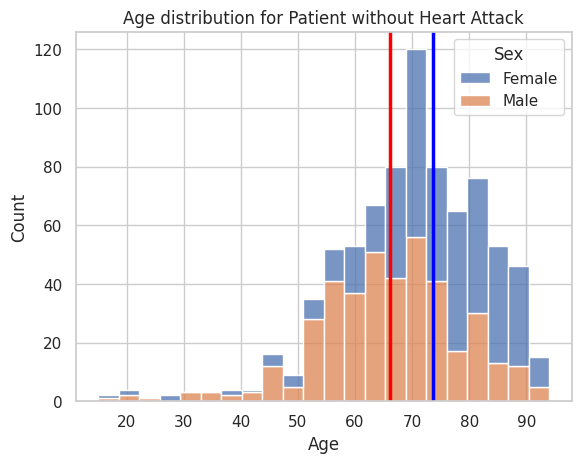

In [ ]:
ax = sns.histplot(df_NOHeartAttack, x="Age",hue="Sex",kde=False, multiple="stack")
ax.set_title('Age distribution for Patient without Heart Attack')
ax.axvline(x=grouped_NOHeartAttack['Male'], c='red', ls='-', lw=2.5)
ax.axvline(x=grouped_NOHeartAttack['Female'], c='blue', ls='-', lw=2.5)

In [ ]:
df.createOrReplaceTempView("check3")

# Query to select patients with heart attack
sql_query = """
    SELECT DiagnosticCode, Age, Sex
    FROM check2
    WHERE DiagnosticCode = 1
"""

df_HeartAttack = sqlCtx.sql(sql_query).toPandas()

grouped_HeartAttack = df_HeartAttack.groupby('Sex')['Age'].mean()

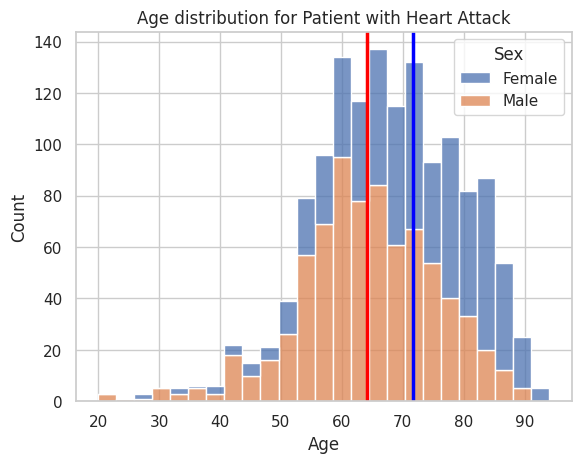

In [ ]:
ax = sns.histplot(df_HeartAttack, x="Age",hue="Sex",kde=False, multiple="stack" )
ax.set_title('Age distribution for Patient with Heart Attack')
ax.axvline(x=grouped_HeartAttack['Male'], c='red', ls='-', lw=2.5)
ax.axvline(x=grouped_HeartAttack['Female'], c='blue', ls='-', lw=2.5)

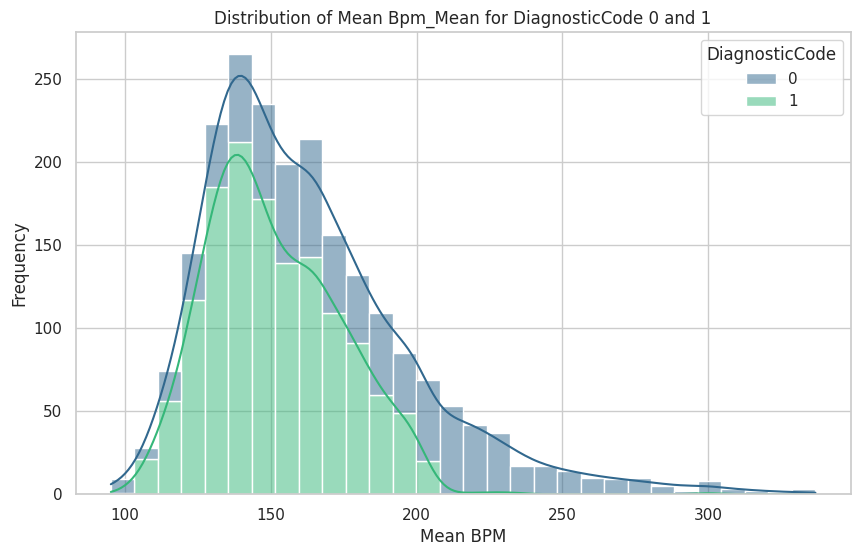

In [ ]:
# Distribution of Mean Bpm of patients, distinct between people with and without an heart attack
bpm_columns = ['Bpm_Mean1', 'Bpm_Mean2', 'Bpm_Mean3', 'Bpm_Mean4', 'Bpm_Mean5', 'Bpm_Mean6',
               'Bpm_Mean7', 'Bpm_Mean8', 'Bpm_Mean9', 'Bpm_Mean10', 'Bpm_Mean11', 'Bpm_Mean12', 'DiagnosticCode']
df_bpm_diagnostic = df.select(bpm_columns).toPandas()

# Calculate the mean of all 'Bpm_Mean' columns
df_bpm_diagnostic['Bpm_Mean_Mean'] = df_bpm_diagnostic.iloc[:, :-1].mean(axis=1)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_bpm_diagnostic, x='Bpm_Mean_Mean', hue='DiagnosticCode', kde=True, bins=30, multiple="stack", palette="viridis")
plt.title('Distribution of Mean Bpm_Mean for DiagnosticCode 0 and 1')
plt.xlabel('Mean BPM')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#to save the partial result in a csv file

'''output_path = "final_df.csv"

import csv

df_stringified = df

for i in range(1, 13):
 # Convert array to a comma-separated string
 df_stringified = df_stringified.withColumn(f"Der{i}", concat_ws(",", col(f"New_der{i}")))

 # Drop the original array column
 df_stringified = df_stringified.drop(f"New_der{i}")

# Repartition the DataFrame to have only final csv
df_stringified = df_stringified.repartition(1)

# Write the DataFrame to CSV
df_stringified.write.csv(output_path, header=True, mode="overwrite")